# Sea Ice Comparisons to Observations

This script shows how to load and plot sea ice concentration from CICE output and compare it to the NSIDC CDR (National Snow and Ice Data Centre, Climate Data Record) dataset

This notebook uses the _ACCESS-NRI Intake Catalog_ following the examples in [Tutorials/Using the Intake Catalog](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Using_Intake_Catalog.html). 

Requirements: The runs analysed here are only in access-nri-intake-catalog version 0.3.1 or newer, and xarray.DataTree introduced in xarray version v2024.10.0. This was tested using `conda/analysis3-25.05` from `/g/data/xp65/public/modules` and a _medium_ instance on _normalsr_ queue (although we recommend a larger instance if making iterative changes). 

**OM2 Experiments:**

These are the ACCESS-OM2 runs we are going to use, we can compare results from prototype runs forced with ERA5 against normal runs using JRA55do, as [described on the ACCESS_HIVE](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103/5). To compare against the observational datasets, we use IAF (Inter-Annual Forcing). _N.B._ The JRA55do runs used here a slightly different to the typical (e.g. _025deg_jra55_iaf_omip2_cycle6_) in the model version used and the timeframes evaluated.

In [1]:
RUNS = {
    "025deg_era5": ["025deg_era5_iaf"],  # (our name: run name(s))
    "025deg_jra55": ["025deg_jra55_iaf_era5comparison"],
    "1deg_era5": ["1deg_era5_iaf"],
    "1deg_jra55": ["1deg_jra55_iaf_era5comparison"],
}

We are going to look at Sea Ice Concentration and Sea Ice Volume

In [2]:
VARS = ["aice_m", "hi_m" ]  # ice area fraction or sea ice concentration, ice thickness averaged by grid cell area
VARS_2D = ["area_t", "geolat_t", "geolon_t"]

**Observational Data:**

Sea Ice concentration is measured through passive microwave remote sensing. We are going to use the NSIDC CDR Dataset (described at [nsidc.org](https://nsidc.org/data/g02202/versions/4))

In [3]:
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"
nh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday"

**Load depenencies:**

In [4]:
import intake
from xarray import DataTree, map_over_datasets

from dask.distributed import Client

import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines

A standard way to calculate climatologies. (We start in 1991 as earlier decades are influenced by model spin-up for 0.25deg runs which only start in 1980.)

In [5]:
CLIMAT_TIME_SLICE = slice("1991", "2020")


def climatology(ds):
    return ds.sel(time=CLIMAT_TIME_SLICE).groupby("time.month").mean("time")

Start a dask client

In [ ]:
client = Client(threads_per_worker = 1)

client.dashboard_link

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45847 instead
  warnings.warn(


Open the _ACCESS-NRI Intake Catalog_

In [7]:
catalog = intake.cat.access_nri

# Load the ACCESS-OM2 results

For CICE data in OM2, we need to do some wrangling to make it easier to deal with. This is described in more detail in [DocumentedExamples/SeaIce_Plot_Example](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/SeaIce_Plot_Example.html). Its included in this function:

In [8]:
def open_by_name(name, vars):
    """Return a dataset for the requested name and vars"""

    return (
        catalog[name]
        .search(variable=vars)
        .to_dask(
            xarray_open_kwargs={
                "chunks": -1 ,
                "decode_coords": False,
            },
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )
    )

In [9]:
def open_by_experiment(exp_name, vars):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""

    # get the data for each run of this config
    cice_ds = xr.concat(
        [open_by_name(iName, vars) for iName in RUNS[exp_name]], dim="time"
    )

    # We also want the area/lat/lon fields, these are separate datasets, so lets merge them.
    area_ds = xr.merge(
        [open_by_name(RUNS[exp_name][0], iVar) for iVar in VARS_2D]
    ).load()

    # Label the lats and lons
    cice_ds.coords["ni"] = area_ds["xt_ocean"].values
    cice_ds.coords["nj"] = area_ds["yt_ocean"].values

    # Copy attributes for cf compliance
    cice_ds.ni.attrs = area_ds.xt_ocean.attrs
    cice_ds.nj.attrs = area_ds.yt_ocean.attrs

    cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))

    # Add the geolon, geolat, and area as extra co-ordinates fields from area_t

    cice_ds = cice_ds.assign_coords(
        {
            "geolat_t": area_ds.geolat_t,
            "geolon_t": area_ds.geolon_t,
            "area_t": area_ds.area_t,
        }
    )

    # cice timestamps are also misleading:
    cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    return cice_ds

Because the dimensions are different for different experiments, they would not fit in a Dataset, a DataTree is required. The DataTree has a group for each experiment, which contains a xarray dataset with the data for that experiment. 

In [10]:
%%time

si_name_ds_pairs = dict()
for run in RUNS.keys():
    si_name_ds_pairs[run] = open_by_experiment(run, VARS)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid

CPU times: user 33.8 s, sys: 7.42 s, total: 41.2 s
Wall time: 37.3 s


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [11]:
si_dt = DataTree.from_dict(si_name_ds_pairs)

In [12]:
def match_timestamps_to_CDR(ds):

    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds

    # make a copy, datatree doesn't allow manipulating in place  
    cice_ds = ds.copy()

    # we are going to use the same timestamps as NSIDC
    cice_ds["time"] = [
        np.datetime64(str(i)[0:7] + "-01T00:00:00.000000000")
        for i in ds.time.values
    ]

    return cice_ds

In [13]:
si_dt = si_dt.map_over_datasets(match_timestamps_to_CDR)

The result is a datatree, with a dataset for each experiment and timestamps which align with the observational timestamps

In [14]:
si_dt

<xarray.DataTree>
Group: /
├── Group: /025deg_era5
│       Dimensions:   (time: 528, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2023-12-01
│         * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
│           geolon_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
│           area_t    (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
│       Data variables:
│           aice_m    (time, yt_ocean, xt_ocean) float32 3GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hi_m      (time, yt_ocean, xt_ocean) float32 3GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/18)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
│           intake_esm_attrs:variable_cell_methods:   ,,,,,,,time: mean,time: mean,,,...
│           intake_esm_attrs:variable_units:          radians,radians,m,m,m,degrees_n...
│           intake_esm_attrs:realm:                   seaIce
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   seaIce.1mon.d2:2.nc:5.ni:1440.n...
├── Group: /025deg_jra55
│       Dimensions:   (time: 528, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2023-12-01
│         * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
│           geolon_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
│           area_t    (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
│       Data variables:
│           aice_m    (time, yt_ocean, xt_ocean) float32 3GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hi_m      (time, yt_ocean, xt_ocean) float32 3GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/18)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
│           intake_esm_attrs:variable_cell_methods:   ,,,,,,,time: mean,time: mean,,,...
│           intake_esm_attrs:variable_units:          radians,radians,m,m,m,degrees_n...
│           intake_esm_attrs:realm:                   seaIce
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   seaIce.1mon.d2:2.nc:5.ni:1440.n...
├── Group: /1deg_era5
│       Dimensions:   (time: 708, yt_ocean: 300, xt_ocean: 360)
│       Coordinates:
│        

# Load the observational dataset

The CDR dataset has the area of each grid cell provided as a separate file, which we need to load

In [15]:
def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds["cdr_conc"] = ds.cdr_conc.where(ds.cdr_conc<=1)  # convert error codes to Nan

    return ds

We can pull the datasets direct from the url, however the cell area needs to be downloaded separately:

In [16]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


We are interested in the Antarctic, but the lines for the Arctic are below and commented out.

In [17]:
sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat")

# nh_cdr_xr = open_cdr_dataset(
#     nh_obs_url,
#     'psn25area_v3.dat'
# )

cdr_dt = DataTree.from_dict(
    {
        "cdr_sh": sh_cdr_xr,
        # 'cdr_nh':nh_cdr_xr
    }
)

The result is a datatree, with a datasets for the relevant hemisphere

# Calculate Sea Ice Area

Sea ice area is the circumpolar sum of sea ice concentration multiplied by the area of each grid cell. By convention, and because lower concentrations are not accurate when measured through remote sensing, concentrations below 0.15 are not included

In [18]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

Calculate for observational data, and remove gaps with missing data

In [19]:
def sea_ice_area_obs(ds):

    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    sic = ds.cdr_conc
    result = sea_ice_area(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)

In [20]:
obs_area_dt = cdr_dt.map_over_datasets(sea_ice_area_obs)

In [21]:
# Theres another gap which should be nan in the arctic only
# obs_area_dt['cdr_nh'].to_dataset().loc[{'time':'1984-07'}]=np.nan

Calculate for model data, limit to southern hemisphere / Antarctica

In [22]:
def sea_ice_area_model_sh(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    sic = ds.aice_m.cf.sel(Y=slice(-90, 0))
    area_km2 = ds.area_t / 1e6

    return sea_ice_area(sic, area_km2).to_dataset(name="si_area").load()

In [23]:
model_area_dt = si_dt.map_over_datasets(sea_ice_area_model_sh)

# Sea Ice Area Trends

We are going to compare the trends in the minima and maxima over time, and the monthly climatology

In [24]:
def min_and_max_year(da):
    result = xr.Dataset()
    result["min"] = da.min()
    result["max"] = da.max()
    return result

def min_and_max(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds

    annual_min_max_ds = ds.si_area.groupby("time.year").apply(min_and_max_year)
    return annual_min_max_ds

model_min_max_dt = model_area_dt.map_over_datasets(min_and_max)

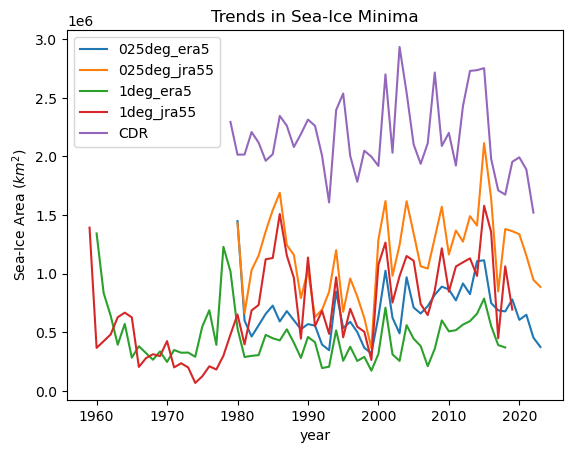

In [25]:
for group in model_min_max_dt.groups[1:]:
    ds = model_min_max_dt[group].ds
    ds["min"].plot(label=group[1:])

obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(label="CDR")

plt.title("Trends in Sea-Ice Minima")
plt.ylabel("Sea-Ice Area ($km^2$)")

_ = plt.legend()

We see that all models have sea ice area which is too low in summer. Model runs forced by JRA have more variability than those forced by ERA5 and are slightly closer to the measured sea ice area from observations.

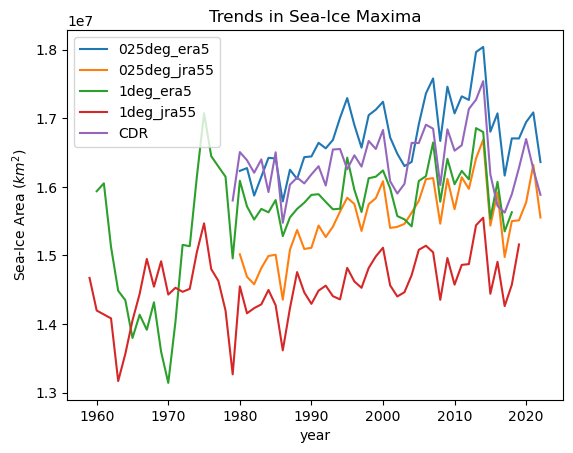

In [26]:
for group in model_min_max_dt.groups[1:]:
    ds = model_min_max_dt[group].ds.sel(
        year=slice(1950, 2022)
    )  # drop 2023 because its incomplete
    ds["max"].plot(label=group[1:])

obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").max().plot(label="CDR")

plt.title("Trends in Sea-Ice Maxima")
plt.ylabel("Sea-Ice Area ($km^2$)")

_ = plt.legend()

We see that the closest runs are those forced by ERA5, and the runs forced by JRA55 are under representing Winter sea ice.

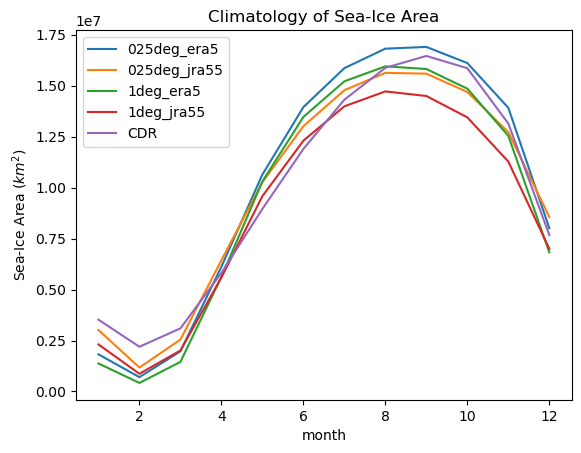

In [27]:
for group in model_area_dt.groups[1:]:
    climatology(model_area_dt[group].ds.si_area).plot(label=group[1:])

climatology(obs_area_dt["cdr_sh"].ds.cdr_area).plot(label="CDR")

plt.title("Climatology of Sea-Ice Area")
plt.ylabel("Sea-Ice Area ($km^2$)")

plt.legend()

We see all model runs have too low sea ice in summer, and grow faster than observations in autumn and earlier that the observed maximum.

# Sea Ice Concentration Anomalies

To examine the differences between the model results and observations, we calculate difference in each grid cell between observations and each experiment

As that data are on different grids, we need to regrid to compare the datasets

Lets simplify a little to only look at 0.25 degree results

In [28]:
groups = ("/025deg_era5", "/025deg_jra55")

The lat/lon of of each cell in the observational dataset are in a different file:

In [29]:
! wget -nc https://noaadata.apps.nsidc.org/NOAA/G02202_V5/ancillary/G02202-ancillary-pss25-v05r00.nc

File ‘G02202-ancillary-pss25-v05r00.nc’ already there; not retrieving.



In [30]:
cdr_sps_ds = xr.open_dataset("G02202-ancillary-pss25-v05r00.nc")

We can now build the re-gridder. This is described in detail in [DocumentedExamples/Regridding](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Regridding.html)

In [31]:
regridder_ACCESSOM2_025deg_sh = xesmf.Regridder(
    si_dt["025deg_era5"].ds.isel(time=0).drop_vars(["xt_ocean", "yt_ocean"]),
    cdr_sps_ds,
    "bilinear",
    periodic=True,
    unmapped_to_nan=True,
)

In [32]:
aice_sh_3976_ds = xr.Dataset()
aice_sh_anom_ds = xr.Dataset()

for iG in groups:
    aice_sh_3976_ds[iG] = regridder_ACCESSOM2_025deg_sh(
        si_dt[iG].ds.aice_m.copy()
    )
    aice_sh_anom_ds[iG] = aice_sh_3976_ds[iG] - cdr_dt["cdr_sh"].ds.cdr_conc

We can now plot the difference between modelled and observed sea ice concentration

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 220.81 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 220.81 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/c

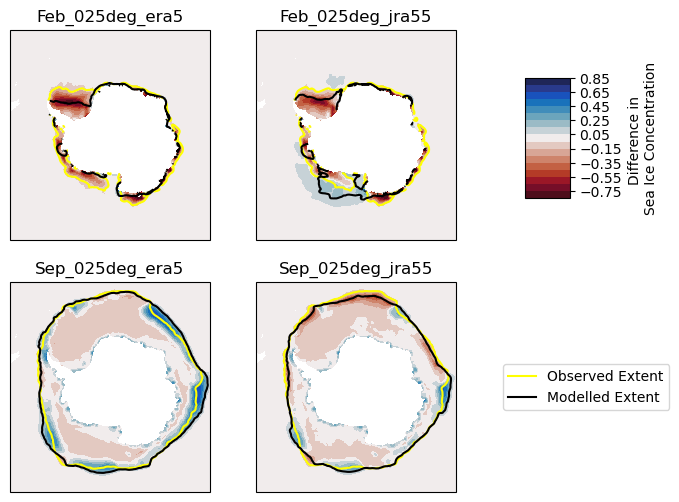

In [33]:
months = [2, 9]  # february, september
month_names = ["Feb", "Sep"]
n_months = len(months)

plt.figure(figsize=(9, n_months * 3))

cdr = climatology(cdr_dt["cdr_sh"].ds.cdr_conc)

for j, group in enumerate(aice_sh_anom_ds.data_vars):
    anoms = climatology(aice_sh_anom_ds[group])
    aice = climatology(aice_sh_3976_ds[group])

    for i, iMonth in enumerate(months):
        plt.subplot(
            n_months,
            3,
            j + 1 + i * 3,
            projection=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        )

        # Filled contours with concentration anomalies in this month
        ds = anoms.sel(month=iMonth).compute()
        plt.contourf(
            ds.x, ds.y, ds, levels=np.arange(-0.85, 0.86, 0.1), cmap=cmo.balance_r
        )

        # Lines at 15% concentration (approx ice edge)
        cs_cdr = cdr.sel(month=iMonth).plot.contour(levels=[0.15], colors=["yellow"])
        cs_mod = aice.sel(month=iMonth).plot.contour(levels=[0.15], colors=["black"])

        plt.title(month_names[i] + "_" + group[1:])

# Messy legend creation
line_cdr = mlines.Line2D([], [], color="yellow", label="Observed Extent")
line_mod = mlines.Line2D([], [], color="black", label="Modelled Extent")

plt.legend(handles=[line_cdr, line_mod], loc="center left", bbox_to_anchor=(1.2, 0.5))

# And colorbar
cax = plt.axes([0.7, 0.6, 0.05, 0.2])
_ = plt.colorbar(cax=cax, label="Difference in \nSea Ice Concentration")

We see that OM2 under-represents sea ice in Summer, particularly in the Weddell Sea. In Winter, trends are less clear, although ERA5 forced sea ice concentration is too high at the northern boundary.

# Sea Ice Volume

We can calculate volume in much the same way as area, except _vicen_ is volume (per unit area) in each of 5 thickness classes, so we can sum this for the volume irrespective of thickness. 

In [34]:
def sea_ice_vol_model_sh(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    vice_m = ds.hi_m.sel(yt_ocean=slice(-90, 0))
    siv_total_da = (
        (vice_m * ds.area_t)
        .where(~np.isnan(ds.area_t))
        .cf.sum(["longitude", "latitude"])
    )

    return siv_total_da.to_dataset(name="si_vol").load()

In [35]:
si_vol_dt = si_dt.map_over_datasets(sea_ice_vol_model_sh)

In [36]:
def min_and_max(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
        
    def min_and_max_year(da):
        result = xr.Dataset()
        result["min"] = da.min()
        result["max"] = da.max()
        return result

    annual_min_max_ds = ds.si_vol.groupby("time.year").apply(min_and_max_year)
    return annual_min_max_ds


model_min_max_dt = si_vol_dt.map_over_datasets(min_and_max)

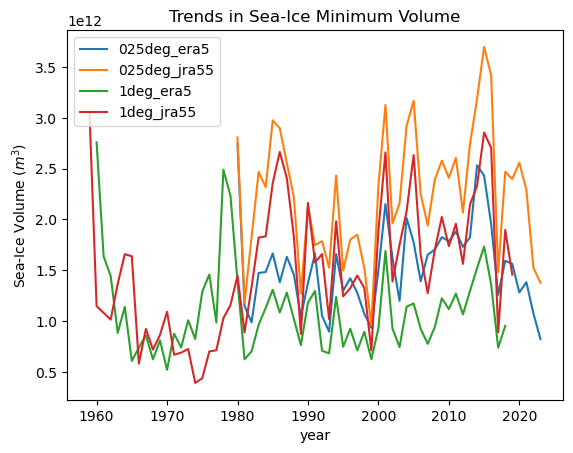

In [37]:
for group in model_min_max_dt.groups[1:]:
    ds = model_min_max_dt[group].ds
    ds["min"].plot(label=group[1:])

plt.title("Trends in Sea-Ice Minimum Volume")
plt.ylabel("Sea-Ice Volume ($m^3$)")

_ = plt.legend()

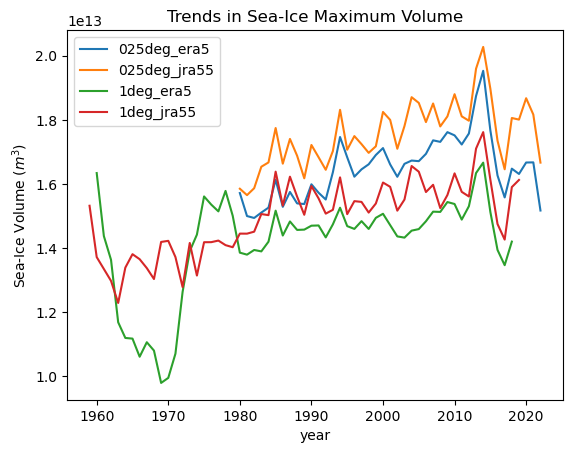

In [38]:
for group in model_min_max_dt.groups[1:]:
    ds = model_min_max_dt[group].ds.sel(
        year=slice(1950, 2022)
    )  # drop the last year because its incomplete
    ds["max"].plot(label=group[1:])

plt.title("Trends in Sea-Ice Maximum Volume")
plt.ylabel("Sea-Ice Volume ($m^3$)")

_ = plt.legend()

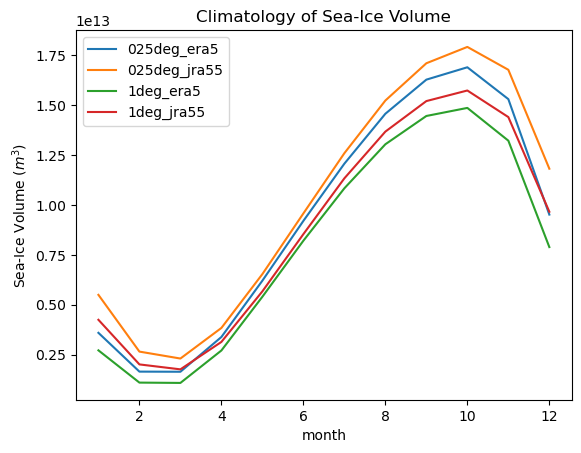

In [39]:
for group in si_vol_dt.groups[1:]:
    climatology(si_vol_dt[group].ds.si_vol).plot(label=group[1:])

plt.title("Climatology of Sea-Ice Volume")
plt.ylabel("Sea-Ice Volume ($m^3$)")

_ = plt.legend()

In [40]:
client.close()